# Contextual Bandits Agent with Policy Gradient Method (Stochastic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import traceback
from tqdm.notebook import tnrange
from scipy.special import logit, expit
from PolicyGradientAgent import StochasticGradientAgent
from Environment import PredictionMarket, Bucket, one_hot_encode, bucket_colour_to_num, not_outlier

In [30]:
learning_rate_theta = 1e-3
learning_rate_wv = 1e-4
memory_size = 2**12
batch_size = 2**12
training_episodes = 30000 * 2
decay_rate = 0
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'
learning_std = False
fixed_std = 0.3
# Bucket parameters
prior_red = 0.5
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3

agent = StochasticGradientAgent(feature_shape=[1, 3], learning_rate_theta=learning_rate_theta, 
                                learning_rate_wv=learning_rate_wv, 
                                memory_size= memory_size, batch_size=batch_size,
                                beta1=beta1, beta2=beta2, 
                                learning_std=learning_std, fixed_std=fixed_std)


reward_history_list = []
regret_history_list = []
average_reward = 0

mean_weights_history_list = []
std_weights_history_list = []

r_ball_mean_history_list = []
b_ball_mean_history_list = []
r_ball_std_history_list = []
b_ball_std_history_list = []

r_ball_pred_history_list = []
b_ball_pred_history_list = []

grad_r_ball_mean_history_list = []
grad_b_ball_mean_history_list = []
grad_r_ball_std_history_list = []
grad_b_ball_std_history_list = []

grad_r_ball_v_mean_history_list = []
grad_b_ball_v_mean_history_list = []
grad_r_ball_v_std_history_list = []
grad_b_ball_v_std_history_list = []

grad_r_ball_adam_mean_history_list = []
grad_b_ball_adam_mean_history_list = []
grad_r_ball_adam_std_history_list = []
grad_b_ball_adam_std_history_list = []

grad_mean_history_list = []
mean_history_list = []
std_history_list = []
report_history_list = []

for t in tnrange(training_episodes):
    bucket = Bucket(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    signal = bucket.signal()
    x = one_hot_encode(signal)
    x.append(prior_red)
    h, mean, std = agent.report(x)
    pi = expit(h)
    report = [pi, 1 - pi]

    pm.report(report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
    average_reward = average_reward + (1/ (t + 1)) * (R - average_reward)
    
    mean_weights_history_list.append(agent.theta_mean[0].tolist())
    std_weights_history_list.append(agent.theta_std[0].tolist())
    
    R_perf = 0
    red_score = np.log(report[0]) - np.log(0.5)
    blue_score = np.log(report[1]) - np.log(0.5)
    red_expectation = pr_red_ball_red_bucket  * red_score + (1 - pr_red_ball_red_bucket)  * blue_score
    blue_expectation = pr_red_ball_blue_bucket  * red_score + (1 - pr_red_ball_blue_bucket)  * blue_score
    red_max_expectation = pr_red_ball_red_bucket * (np.log(pr_red_ball_red_bucket) - np.log(0.5)) + (1 - pr_red_ball_red_bucket) * (np.log(1 - pr_red_ball_red_bucket) - np.log(0.5))
    blue_max_expectation = pr_red_ball_blue_bucket * (np.log(pr_red_ball_blue_bucket) - np.log(0.5)) + (1 - pr_red_ball_blue_bucket) * (np.log(1 - pr_red_ball_blue_bucket) - np.log(0.5))
    if signal == 'red':
        R_perf = red_expectation
        regret = red_max_expectation - red_expectation
    else:
        R_perf = blue_expectation
        regret = blue_max_expectation - blue_expectation
    regret_history_list.append(regret)

    v = agent.store_experience(x, h, mean, std, R, t)
    
    reward_history_list.append([R, average_reward, v, signal])
    try:
        grad_mean, grad_std, v_dw_mean_corrected, v_dw_std_corrected, \
        s_dw_mean_corrected, s_dw_std_corrected = agent.batch_update(t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)

    agent.learning_rate_decay(epoch=t, decay_rate=decay_rate)

    if signal == 'red':
        r_ball_pred_history_list.append(report[0])
        r_ball_mean_history_list.append(mean)
        r_ball_std_history_list.append(std)
       
    else:
        b_ball_pred_history_list.append(report[0])
        b_ball_mean_history_list.append(mean)
        b_ball_std_history_list.append(std)
    
    report_history_list.append([report[0], signal])
    mean_history_list.append([mean, signal])
    std_history_list.append([std, signal])
    grad_mean_history_list.append(grad_mean[0, :])
    
    grad_r_ball_mean_history_list.append(grad_mean[0, 0])
    grad_r_ball_std_history_list.append(grad_std[0, 0])
    ##########
    grad_r_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 0])
    grad_r_ball_v_std_history_list.append(v_dw_std_corrected[0, 0])
    grad_r_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 0])
    grad_r_ball_adam_std_history_list.append(s_dw_std_corrected[0, 0])
    ##################################################################
    grad_b_ball_mean_history_list.append(grad_mean[0, 1])
    grad_b_ball_std_history_list.append(grad_std[0, 1])
    ##########
    grad_b_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 1])
    grad_b_ball_v_std_history_list.append(v_dw_std_corrected[0, 1])
    grad_b_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 1])
    grad_b_ball_adam_std_history_list.append(s_dw_std_corrected[0, 1])

  0%|          | 0/60000 [00:00<?, ?it/s]

Updating weights with regular algorithm.


In [31]:
# reward_history = np.array(reward_history_list)
reward_history_df = pd.DataFrame(reward_history_list, columns=['actual_reward', 'average_reward', 'estimated_reward', 'signal'])
regret_history = np.array(regret_history_list)

mean_weights_history = np.array(mean_weights_history_list)
std_weights_history = np.array(std_weights_history_list)

grad_r_ball_mean_history = np.array(grad_r_ball_mean_history_list)
grad_b_ball_mean_history = np.array(grad_b_ball_mean_history_list)
grad_r_ball_std_history = np.array(grad_r_ball_std_history_list)
grad_b_ball_std_history = np.array(grad_b_ball_std_history_list)

grad_r_ball_v_mean_history = np.array(grad_r_ball_v_mean_history_list)
grad_b_ball_v_mean_history = np.array(grad_b_ball_v_mean_history_list)
grad_r_ball_v_std_history = np.array(grad_r_ball_v_std_history_list)
grad_b_ball_v_std_history = np.array(grad_b_ball_v_std_history_list)

grad_r_ball_adam_mean_history = np.array(grad_r_ball_adam_mean_history_list)
grad_b_ball_adam_mean_history = np.array(grad_b_ball_adam_mean_history_list)
grad_r_ball_adam_std_history = np.array(grad_r_ball_adam_std_history_list)
grad_b_ball_adam_std_history = np.array(grad_b_ball_adam_std_history_list)

grad_mean_history_df = pd.DataFrame(grad_mean_history_list, columns=['red_ball', 'blue_ball', 'prior'])
report_history_df = pd.DataFrame(report_history_list, columns=['report', 'signal'])
mean_history_df = pd.DataFrame(mean_history_list, columns=['mean', 'signal'])
std_history_df = pd.DataFrame(std_history_list, columns=['std', 'signal'])

In [32]:
std

0.3

Towards best ratio:  0.727138180734235


Text(0.5, 0.98, 'Actual Rewards and Average')

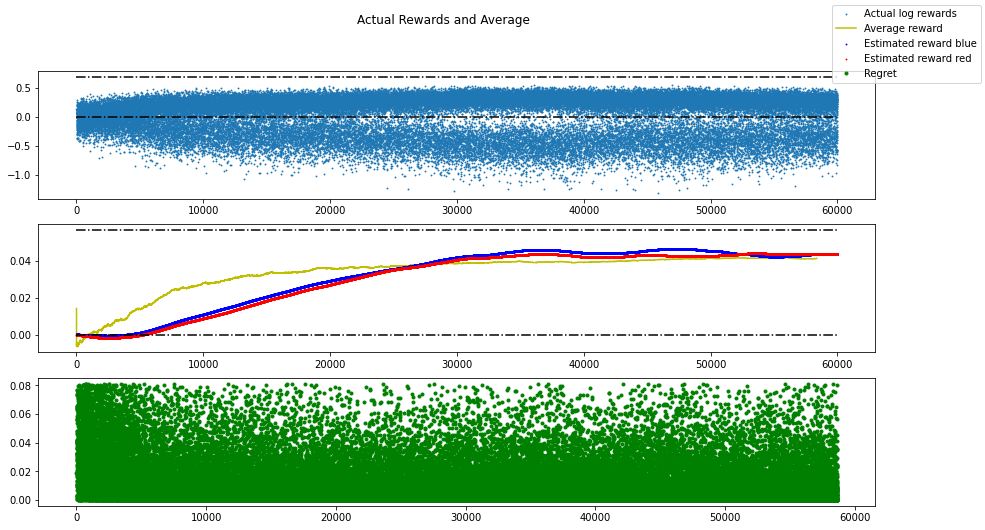

In [40]:
theoretical_best = 2/3*(np.log(2/3)-np.log(1/2)) + 1/3*(np.log(1/3)-np.log(1/2))
empirical_best = reward_history_df.iloc[-100:, 1].mean()
print('Towards best ratio: ', empirical_best/ theoretical_best)
fig, axs = plt.subplots(3, figsize=(15, 8))
axs[0].scatter(x=reward_history_df.index, y=reward_history_df['actual_reward'],label = 'Actual log rewards', marker='.', s=3)
axs[1].plot(not_outlier(reward_history[:, 1]), 'y',zorder= -99, label = 'Average reward')
axs[2].plot(not_outlier(regret_history), 'g.',label='Regret')
axs[0].hlines(y=np.log(2), xmin=0, xmax=reward_history.shape[0], colors='black', linestyles='dashdot')
axs[0].hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
for signal, df in reward_history_df.reset_index().groupby('signal'):
    axs[1].scatter(x=df['index'], y=df['estimated_reward'], label='Estimated reward ' + signal, marker='.', c=signal, s=3)
axs[1].hlines(y=theoretical_best, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Actual Rewards and Average')

Text(0.5, 1.0, 'Report')

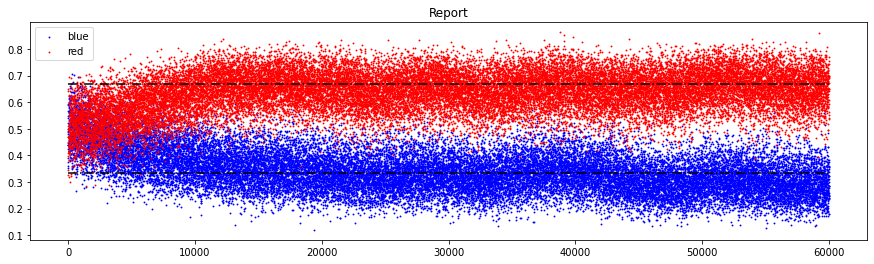

In [6]:
fig, ax = plt.subplots(figsize=(15, 4))
for signal, df in report_history_df.reset_index().groupby('signal'):
    ax.scatter(x=df['index'], y=df['report'], label=signal, marker='.', c=signal, s=3)
ax.hlines(y=2/3, xmin=0, xmax=len(report_history_df), colors='black', linestyles='dashdot')
ax.hlines(y=1/3, xmin=0, xmax=len(report_history_df) , colors='black', linestyles='dashdot')
ax.legend()
plt.title('Report')

In [7]:
grad_mean_successive_dot = np.sum(grad_mean_history_df.values * np.roll(grad_mean_history_df.values, 1, axis=0), axis=1)[1:]
grad_mean_successive_dot

array([-3.71299168e-05,  1.65029759e-02,  1.07406355e-01, ...,
        5.00282103e-04,  5.20614171e-04,  5.18977561e-04])

In [8]:
(mark_index, ) = np.where(grad_mean_successive_dot < 0)
mark_index

array([    0, 24726, 24727, 24737, 24738, 24838, 24857])

In [9]:
def phase_change_coordinates(mark_index, df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    coord_list = []
    prev_x = 0
    for x in mark_index:
        if x > 50:
            if x > prev_x + 1000:
                coord_list.append((x, df.select_dtypes(include=numerics).loc[x, :].max()))
                prev_x = x
    return coord_list

In [10]:
phase_change_coordinates(mark_index, grad_mean_history_df)

[(24726, 0.00010886038741860757)]

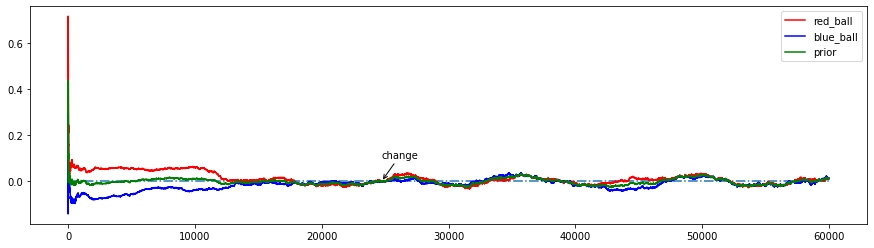

In [11]:
fig, ax = plt.subplots(figsize=(15, 4))
grad_mean_history_df.plot(ax=ax, color=['red', 'blue', 'green'])
ax.hlines(y=0, xmin=0, xmax=len(grad_mean_history_df), linestyles='dashdot')
for coord in phase_change_coordinates(mark_index, grad_mean_history_df):
    plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))

In [12]:
from scipy.ndimage import uniform_filter1d

Text(0.5, 1.0, 'Successive gradients dot product size 1000 moving average')

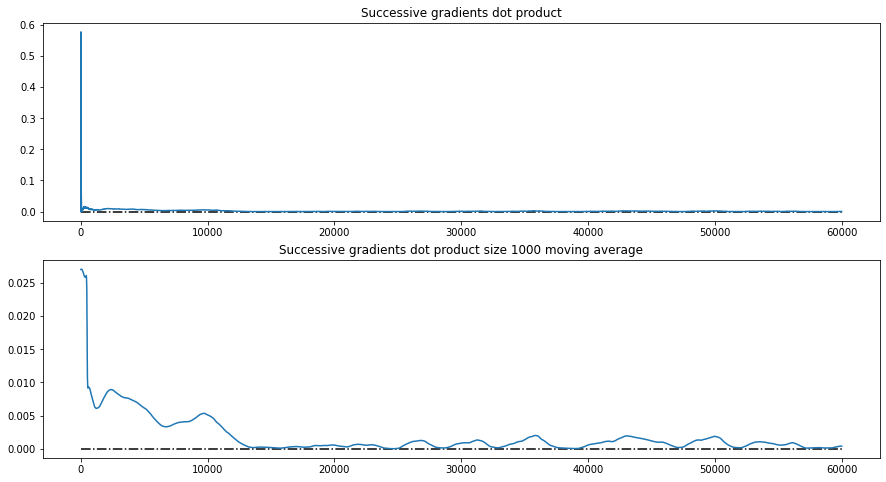

In [13]:
moving_size = 1000
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_mean_successive_dot)
axs[0].hlines(y=0, xmin=0, xmax=len(grad_mean_successive_dot), linestyles='dashdot', color='black')
axs[0].set_title('Successive gradients dot product')
axs[1].plot(uniform_filter1d(grad_mean_successive_dot, size=moving_size))
axs[1].hlines(y=0, xmin=0, xmax=len(grad_mean_successive_dot), linestyles='dashdot', color='black')
axs[1].set_title('Successive gradients dot product size %i moving average'%moving_size)

In [14]:
import matplotlib.lines as mlines

Text(0.5, 1.0, 'Mean')

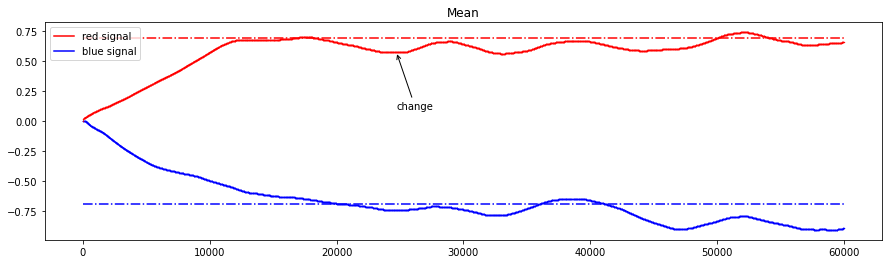

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))
for signal, df in mean_history_df.reset_index().groupby('signal'):
    ax.scatter(x=df['index'], y=df['mean'], label=signal, marker='.', c=signal, alpha=0.6, s=0.1)
plt.hlines(y=np.log(2), xmin=0, xmax=len(mean_history_df), colors='red', linestyles='dashdot')
plt.hlines(y=np.log(1/2), xmin=0, xmax=len(mean_history_df) , colors='blue', linestyles='dashdot')
red_line = mlines.Line2D([], [], color='red', label='red signal')
blue_line = mlines.Line2D([], [], color='blue', label='blue signal')
for coord in phase_change_coordinates(mark_index, mean_history_df):
    plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))
ax.legend(handles=[red_line, blue_line])
plt.title('Mean')

In [16]:
red_line

Text(0.5, 1.0, 'Weights for Mean')

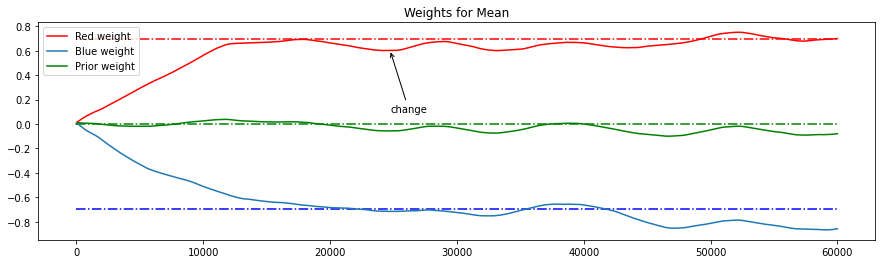

In [17]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history[1:, 1], label='Blue weight')
plt.plot(mean_weights_history[1:, 2], 'g', label='Prior weight')
plt.hlines(y=np.log(2), xmin=0, xmax=len(mean_weights_history), colors='red', linestyles='dashdot')
plt.hlines(y=np.log(1/2), xmin=0, xmax=len(mean_weights_history) , colors='blue', linestyles='dashdot')
plt.hlines(y=0, xmin=0, xmax=len(mean_weights_history) , colors='green', linestyles='dashdot')
for coord in phase_change_coordinates(mark_index, pd.DataFrame(mean_weights_history)):
    plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))
plt.legend()
plt.title('Weights for Mean')

In [18]:
if learning_std:
    min_std = std_history_df['std'].min()
    fig, ax = plt.subplots(figsize=(15, 4))
    for signal, df in std_history_df.reset_index().groupby('signal'):
        ax.scatter(x=df['index'], y=df['std'], label=signal, marker='.', c=signal, s=0.1)
    plt.hlines(y=0, xmin=0, xmax=len(std_history_df) , colors='black', linestyles='dashdot')
    plt.hlines(y=min_std, xmin=0, xmax=len(std_history_df) , colors='black', linestyles='dashdot', label=str(min_std))
    red_line = mlines.Line2D([], [], color='red', label='red signal')
    blue_line = mlines.Line2D([], [], color='blue', label='blue signal')
    ax.legend(handles=[red_line, blue_line])
    plt.title('Standard Diviation')

In [19]:
if learning_std:
    fig = plt.figure(figsize=(15, 4))
    plt.plot(std_weights_history[:, 0], 'r', label='Red weight')
    plt.plot(std_weights_history[:, 1], label='Blue weight')
    plt.plot(std_weights_history[:, 2], 'g', label='Prior weight')
    plt.legend()
    plt.title('Weights for standard diviation')

Text(0.5, 0.98, 'Signal Mean Gradients')

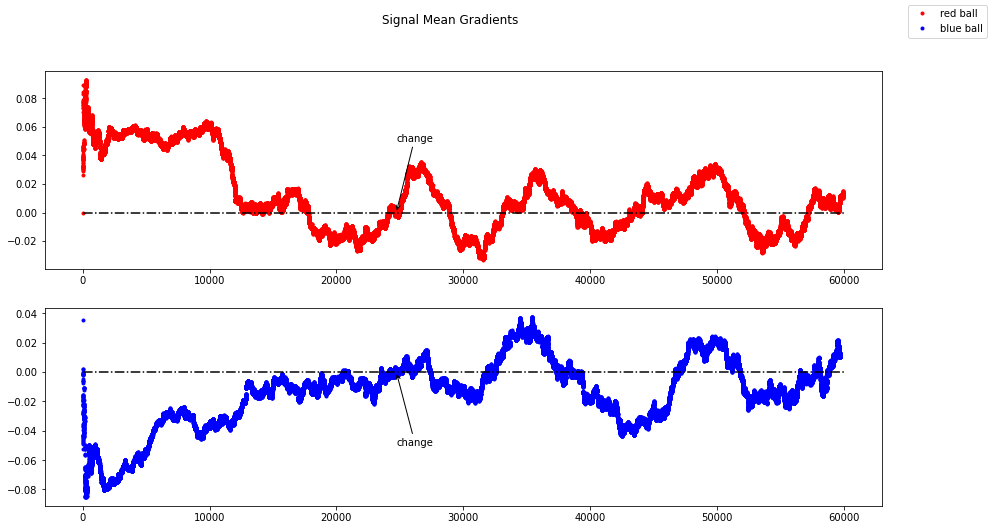

In [20]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(not_outlier(grad_r_ball_mean_history), 'r.', label = 'red ball', zorder=-100)
axs[1].plot(not_outlier(grad_b_ball_mean_history),'b.',label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
for coord in phase_change_coordinates(mark_index, pd.DataFrame(grad_r_ball_mean_history)):
    axs[0].annotate('change', xy=coord, xytext=(coord[0], 0.05), arrowprops=dict(arrowstyle="->"))
for coord in phase_change_coordinates(mark_index, pd.DataFrame(grad_b_ball_mean_history)):
    axs[1].annotate('change', xy=coord, xytext=(coord[0], -0.05), arrowprops=dict(arrowstyle="->"))    
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients (momentum)')

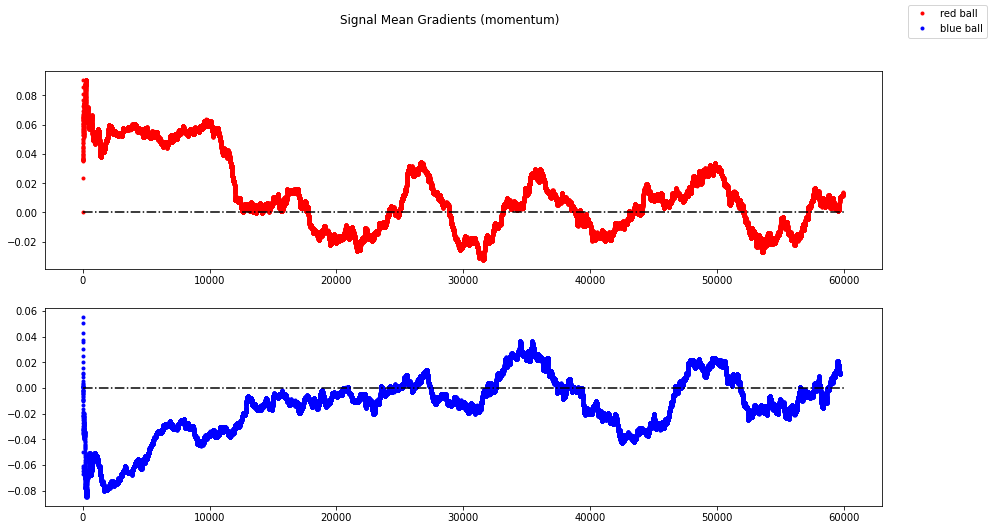

In [21]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(not_outlier(grad_r_ball_v_mean_history), 'r.', label = 'red ball', zorder=-100)
axs[1].plot(not_outlier(grad_b_ball_v_mean_history), 'b.',label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (momentum)')

Text(0.5, 0.98, 'Signal Mean Gradients (Adam)')

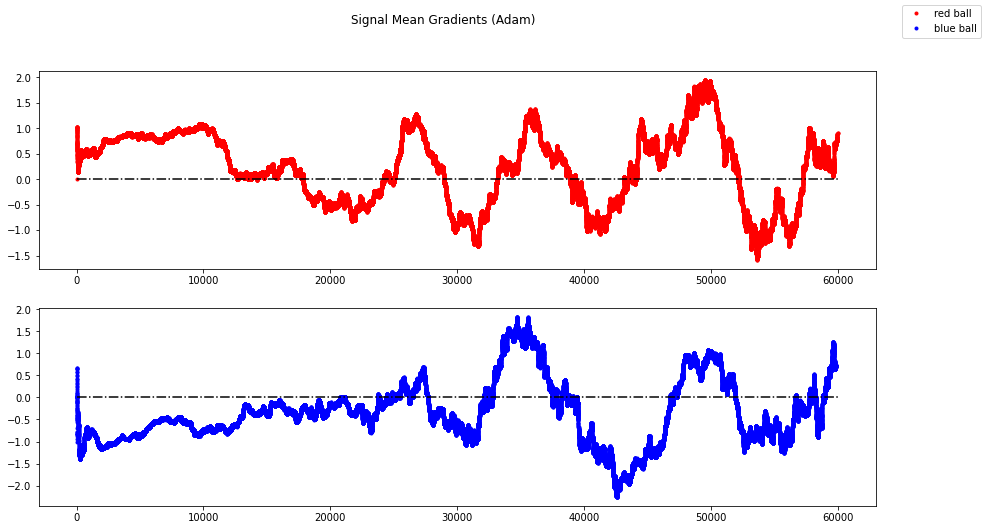

In [22]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(not_outlier(grad_r_ball_adam_mean_history), 'r.', label = 'red ball', zorder=-100)
axs[1].plot(not_outlier(grad_b_ball_adam_mean_history), 'b.',label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (Adam)')

In [23]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(not_outlier(grad_r_ball_mean_history[:, 2]), 'r.', label = 'red ball', zorder = -100)
# axs[1].plot(not_outlier(grad_b_ball_mean_history[:, 2]), 'b.',label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient')

In [24]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(not_outlier(grad_r_ball_v_mean_history[:, 2]), 'r.', label = 'red ball', zorder = -100)
# axs[1].plot(not_outlier(grad_b_ball_v_mean_history[:, 2]),'b.',label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient (Momentum)')

In [25]:
if learning_std:
    fig, axs = plt.subplots(2, figsize=(15, 8))
    axs[0].plot(not_outlier(grad_r_ball_std_history), 'r.', label = 'red ball', zorder = -100)
    axs[1].plot(not_outlier(grad_b_ball_std_history), 'b.',label = 'blue ball', zorder = -100)
    axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_std_history.shape[0], colors='black', linestyles='dashdot')
    axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_std_history.shape[0], colors='black', linestyles='dashdot')
    fig.legend()
    fig.suptitle('Signal Standard Diviation Gradient')

In [26]:
if learning_std:
    fig, axs = plt.subplots(2, figsize=(15, 8))
    axs[0].plot(not_outlier(grad_r_ball_v_std_history), 'r.', label = 'red ball', zorder = -100)
    axs[1].plot(not_outlier(grad_b_ball_v_std_history), 'b.',label = 'blue ball', zorder = -100)
    axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
    axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
    fig.legend()
    fig.suptitle('Signal Standard Diviation Gradient (Momentum)')

In [27]:
if learning_std:
    fig, axs = plt.subplots(2, figsize=(15, 8))
    axs[0].plot(not_outlier(grad_r_ball_adam_std_history), 'r.', label = 'red ball', zorder=-100)
    axs[1].plot(not_outlier(grad_b_ball_adam_std_history), 'b.',label = 'blue ball', zorder=-100)
    axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
    axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
    fig.legend()
    fig.suptitle('Signal Standard Diviation Gradient (Adam)')

In [28]:
np.dot([1, 1], [1, 0])

1